In [1]:
# Import numpy and TF backend
import numpy as np
import os
import tensorflow as tf
tf.python.control_flow_ops = tf

# Import Keras 
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Cropping2D, Lambda
from keras import backend as K

# Import cv
import cv2
import csv
import sklearn



Using TensorFlow backend.


In [2]:
# Find the input data format 
print('In put Data format:', K.image_dim_ordering())
# Global variables
# Store the folders where the training data is located
dataFolders = []
homeFolder = os.getenv("HOME")
#dataFolders.append(homeFolder+'/Data/')
#dataFolders.append(homeFolder+'/Desktop/data/')
#dataFolders.append(homeFolder+'/Car_data/Turns1/data/')
#dataFolders.append(homeFolder+'/Car_data/Turns2/data/')
#dataFolders.append(homeFolder+'/Car_data/Turns3/data/')
dataFolders.append(homeFolder+'/Car_data/Straight1/')
dataFolders.append(homeFolder+'/Car_data/Straight2/')

In put Data format: tf


In [3]:
# Functions

# get ImageMat for the given file location in the Data log
def process_image(folder, imageField):
    imagePath = imageField
    fileName = imagePath.split('/')[-1]
    fileNamewithFolder = folder +'/IMG/' + fileName
    imageMat = cv2.imread(fileNamewithFolder)
    
    return imageMat
# This function reads the numbers of records from the log file as specified by batch size (which is 32 by default)
# essentially 5*batch_size training records
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            msm_init_count = len(angles)
            for batch_sample in batch_samples:
                
                # For each line in the log file, it is getting 3 images and center 
                # steering angle
                # Create 3 training samples for each of center, left, and right captured images and its 
                # corresponding steering angles (left and right are derived from the center sterring angle with 
                # and applied correction of 0.25 - got this correction by trail and error)
                
                # As part of the Image Augmentation the following data points are created
                #  - Flipped images for left and right captures images and its steering angles
                
                # Now for each line in the log there are 5 training samples generated.
                
                # Read the center image (first one from the parsed list)
                imageMat = cv2.imread(batch_sample[0])
                steering_center = float(batch_sample[3])
                images.append(imageMat)
                angles.append(steering_center)
                
                # create adjusted steering measurements for the side camera images
                correction = 0.25 # this is a parameter to tune
                steering_left = steering_center + correction
                steering_right = steering_center - correction

                # read in images from left camera
                imageMat =  cv2.imread(batch_sample[1])
                images.append(imageMat)
                angles.append(steering_left)
                
                # Now add the image flip side to reduce the left bias
                image_flipped_l = np.fliplr(imageMat)
                msmt_flipped = -1 * steering_left
                images.append(image_flipped_l)
                angles.append(msmt_flipped)
                
                # read in images from right camera
                imageMat =  cv2.imread(batch_sample[2])
                images.append(imageMat)
                angles.append(steering_right)
                
                # Now add the image flip side to reduce the right bias
                image_flipped_r = np.fliplr(imageMat)
                msmt_flipped = -1 * steering_right
                images.append(image_flipped_r)
                angles.append(msmt_flipped)


            # Convert the images and steering angles array into numpy array 
            # (4D tensor for Images and 2D tensor for steering angles)
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [4]:
# store each line from the driving_log.csv from each recording session that is in dataFolders
lines = []

# For each folder in dataFolders
for dataFolder in dataFolders:
    # Open the driving_log.csv file as csvfile
    with open(dataFolder+'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
        print('Number of lines read so far:', len(lines))

from sklearn.model_selection import train_test_split

# Split the lines into training and validation samples (20% for validation set)
train_samples, validation_samples = train_test_split(lines, test_size=0.2)


Number of lines read so far: 3027
Number of lines read so far: 7253


In [5]:
# Set the traing and validation data generators
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)
#print(len(train_generator))

In [6]:
# Build the Fully Connected Neural Network in Keras Here
# Here the model is imitating AlexNet structure with some changes to the kernel sizes as the
# input image size is smaller than the 227x227 size
model = Sequential()

# Input normalization 
# Divide each pixel by 255 and get the range os values to be in between -0.5 to 0.5

# Input data is passed in the form of NHWC (as it is the dataformat for Tensorflow)
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

# Trim image to only see section with road - cut top 50 pixels and bottom 20 pixels 
# Take out the top portion that is not road and bottom portion mostly capturing the hood
# Now the resulting image size is 320x90x3 or 90x320x3 as the input is with NHWC format
# (Not efficient way - could have done before)
model.add(Cropping2D(cropping=((50,20), (0,0))))

# First convolution layer with 64 7x7 convs
# Input image/Tensor 90x320x3
# Output generates: 84x314x64 (with stride of 1 and border = valid)
model.add(Convolution2D(64, 7, 7,
                activation='relu',
                border_mode='valid'))

# Max Pooling
# Input Tensor 84x314x64
# Output generates: 28x104x64 (with stride of 1 and border = valid)
model.add(MaxPooling2D((3, 3)))

# Second convolution layer with 128 5x5 convs
# Input Tensor 28x104x64
# Output generates: 24x100x128 (with stride of 1 and border = valid)
model.add(Convolution2D(128, 5, 5,
                activation='relu',
                border_mode='valid'))

# Max Pooling
# Input Tensor 24x100x128
# Output generates: 12x50x128 (with stride of 1 and border = valid)
model.add(MaxPooling2D((2, 2)))

# Third convolution layer with 256 3x3 convs
# Input Tensor 12x50x128
# Output generates: 10x48x256(with stride of 1 and border = valid)
model.add(Convolution2D(256, 3, 3,
                activation='relu',
                border_mode='valid'))

# Fourth convolution layer with 384 3x3 convs
# Input Tensor 10x48x256
# Output generates: 8x46x384(with stride of 1 and border = valid)
model.add(Convolution2D(384, 3, 3, activation='relu'))

# Fifth convolution layer with 256 3x3 convs
# Input Tensor 8x46x384
# Output generates: 6x44x256(with stride of 1 and border = valid)
model.add(Convolution2D(256, 3, 3, activation='relu'))

# Max Pooling
# Input Tensor 6x44x256
# Output generates: 3x22x256 (with stride of 1 and border = valid)
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

# Flatten
# Input Tensor 3x22x256
# Output generates: 16896 1D Tensor
model.add(Flatten())

# 1st fully connected layer
# Input Tensor 16896 
# Output generates: 524 1D Tensor
model.add(Dense(524))

# Add dropout to avoid overfitting on training 
model.add(Dropout(0.5))

# 2nd FC layer
# Input Tensor 524 
# Output generates: 64 1D Tensor
model.add(Dense(64))

# Last layer connected layer - one node at the end to predict steering (basically regression)
# Input Tensor 64 
# Output generates: 1 1D Tensor
model.add(Dense(1))

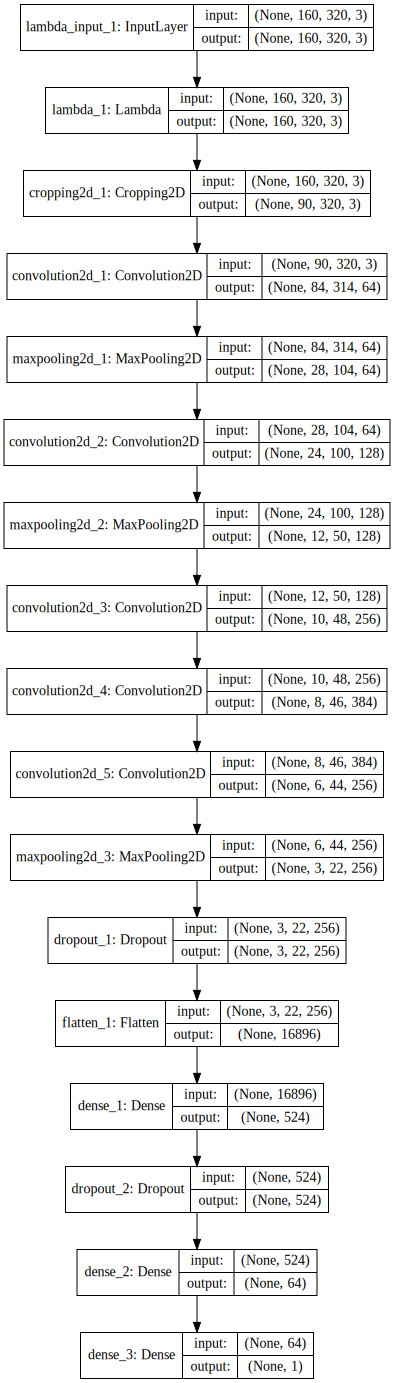

In [7]:
# Show the structure of the model
from keras.utils.visualize_util import plot
from IPython.display import Image, display, SVG
from keras.utils.visualize_util import model_to_dot

figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

plot(model, to_file='model.png')

In [8]:
# Times the the augmented data is generated for each line 
nAugmentedFactor = 5

# Train the model - report loss, and accuracy for training and validation
# Loss is measured as Mean Squared Error as the ouput is a single value and it is continuous (regression)
# Tried to capture the accuracy metric (which may not make sense as it is not categorical value 
# and since it is a continuous value it will hardly match with the ground truth)

# Tried both sgd and adam optimizers. With SGD, it cannot go 1 turn successfully and its loss on validation is 0.035 
# which is higher than the validtion obtained with adam optimizer (which is under 0.03
model.compile(loss='mse', optimizer='adam')
#history = model.fit(X_train, Y_train, nb_epoch=5, validation_split=0.2, shuffle=True)

# Store the loss and accuracy for both training and validation data for each epoch
history_object = model.fit_generator(train_generator, samples_per_epoch= 
            nAugmentedFactor*len(train_samples), validation_data=validation_generator, 
            nb_val_samples=nAugmentedFactor*len(validation_samples), nb_epoch=10)

# Save the model to be used in testing the autonomous mode for the car
model.save('bc_model_jul15.h5')



Epoch 1/10
29010/29010 [==============================] - 84s - loss: 0.1599 - val_loss: 0.0394
Epoch 2/10
29010/29010 [==============================] - 80s - loss: 0.0392 - val_loss: 0.0372
Epoch 3/10
29010/29010 [==============================] - 80s - loss: 0.0378 - val_loss: 0.0352
Epoch 4/10
29010/29010 [==============================] - 79s - loss: 0.0365 - val_loss: 0.0335
Epoch 5/10
29010/29010 [==============================] - 80s - loss: 0.0357 - val_loss: 0.0344
Epoch 6/10
29010/29010 [==============================] - 79s - loss: 0.0344 - val_loss: 0.0332
Epoch 7/10
29010/29010 [==============================] - 79s - loss: 0.0340 - val_loss: 0.0316
Epoch 8/10
29010/29010 [==============================] - 79s - loss: 0.0332 - val_loss: 0.0330
Epoch 9/10
29010/29010 [==============================] - 80s - loss: 0.0327 - val_loss: 0.0326
Epoch 10/10
29010/29010 [==============================] - 80s - loss: 0.0318 - val_loss: 0.0344


dict_keys(['loss', 'val_loss'])


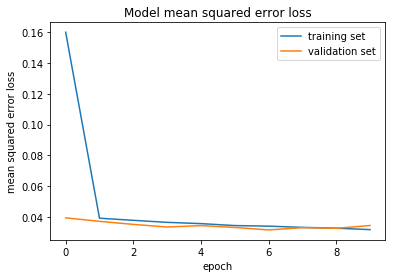

In [9]:
# print the keys contained in the history object
print(history_object.history.keys())

# plot the training and validation loss for each epoch
import matplotlib.pyplot as plt
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('Model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()